In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from IPython.display import Image

# First Load the Image

In [2]:
base_path = "IMG_FROM_FRAME"
files = os.listdir(base_path)
files = [os.path.join(base_path, file) for file in files]

image = None

def load_image(image_filename):
    img = mpimg.imread(image_filename)
    global image
    image = img
    print("Image: %s loaded" % image_filename)
    
interact_manual(load_image, image_filename=files)

Image: IMG_FROM_FRAME/frame104.jpg loaded


# Do Canny Edge Detection

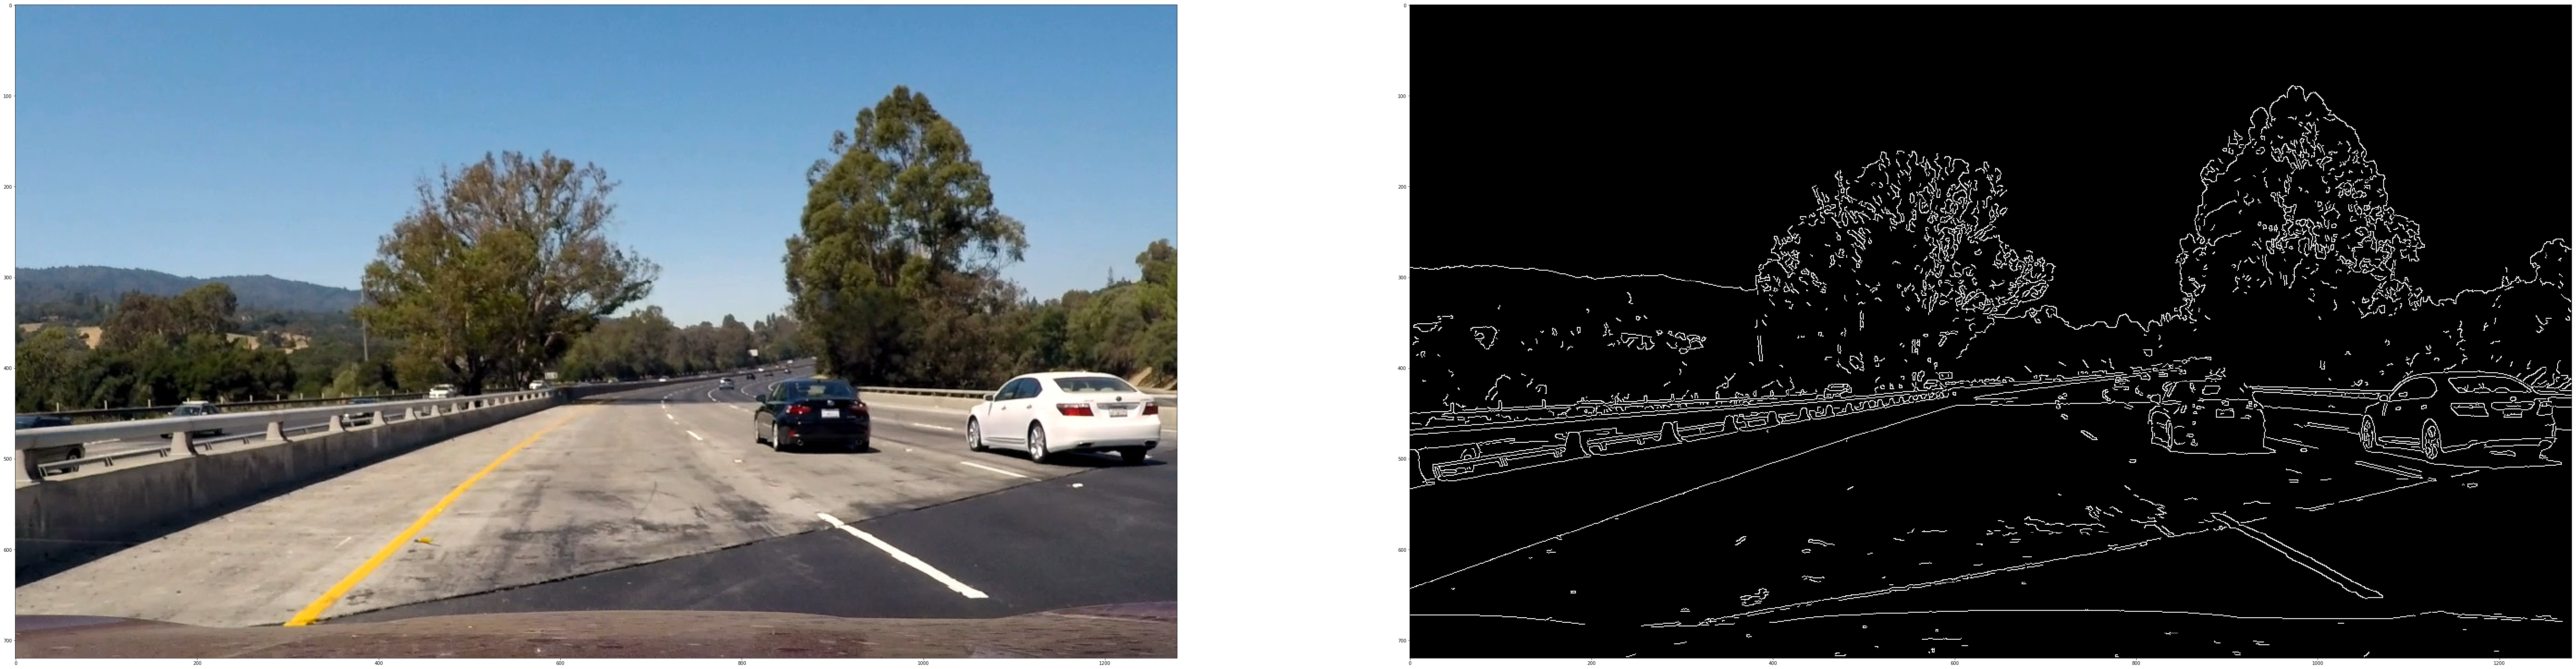

In [3]:
canny_image = None
def canny_edge(gaussian_blur, canny_low_threshold, canny_high_threshold):
    global image, canny_image
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = gaussian_blur
    blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    
    # Define our parameters for Canny and apply
    canny_image = cv2.Canny(blur_gray, canny_low_threshold, canny_high_threshold)
        
    plt.clf()
    fig = plt.figure(figsize=(100, 100))
    
    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.subplot(2, 2, 2)
    plt.imshow(canny_image, cmap='gray')
    plt.show()
    
interact_manual(canny_edge,
         gaussian_blur=widgets.IntSlider(min=1,max=11,step=2,value=1,continuous_update=False),
         canny_low_threshold=widgets.IntSlider(min=1,max=255,step=1,value=50,continuous_update=False),
         canny_high_threshold=widgets.IntSlider(min=1,max=255,step=1,value=150,continuous_update=False))

# Region Of Interest

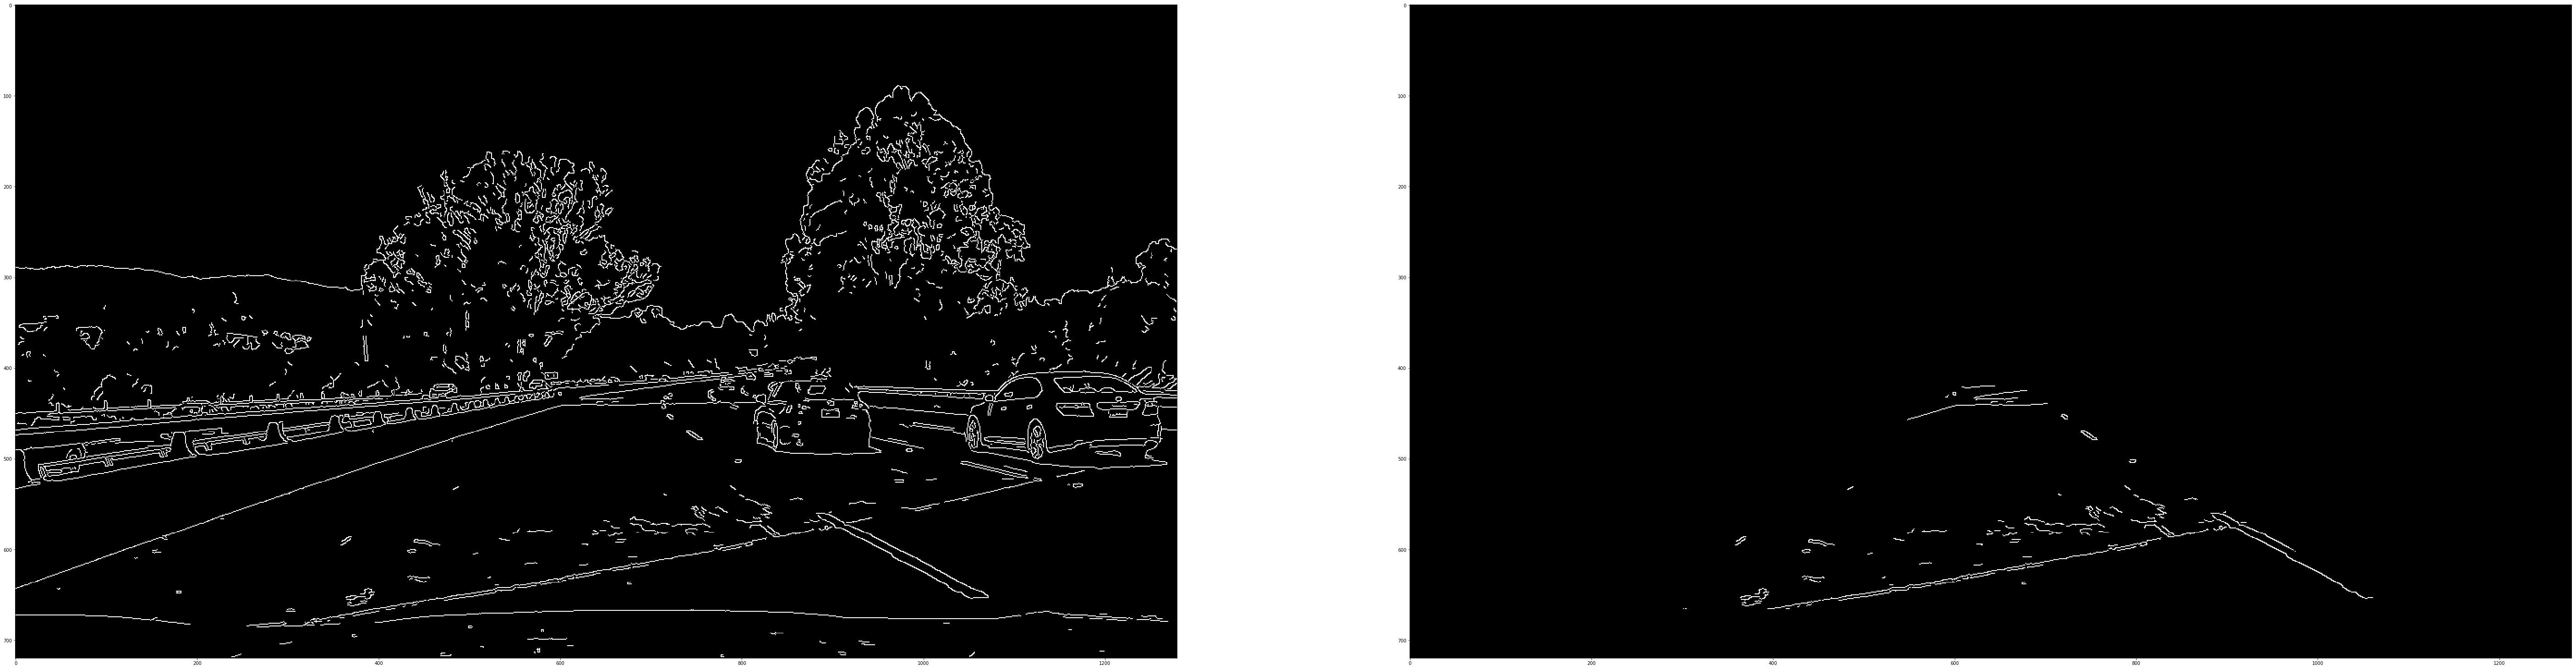

In [4]:
roi_image = None

def region_of_interest():
    global canny_image, roi_image
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(canny_image)
    ignore_mask_color = 255
    
    imshape = image.shape
    height = imshape[0]
    width = imshape[1]
    
    center_x = width / 2
    center_y = height / 2
    x_offset = 30
    y_offset = 240

    left_offset = 200
    bottom_offset = 55

    roi_vertices = np.array([[(left_offset, height - bottom_offset),
                              (center_x - x_offset, center_y / 2 + y_offset),
                              (center_x + x_offset, center_y / 2 + y_offset),
                              (width - left_offset, height - bottom_offset)]],
                              dtype=np.int32)

    # Region of Interest
    cv2.fillPoly(mask, roi_vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(canny_image, mask)
    
    roi_image = masked_edges
    
    masked_rgb = np.dstack((masked_edges, masked_edges, masked_edges))
    
    plt.clf()
    fig = plt.figure(figsize=(100, 100))
    
    plt.subplot(2, 2, 1)
    plt.imshow(canny_image, cmap='gray')
    plt.subplot(2, 2, 2)
    plt.imshow(masked_rgb, cmap='gray')
    
region_of_interest()

# Hough Transform

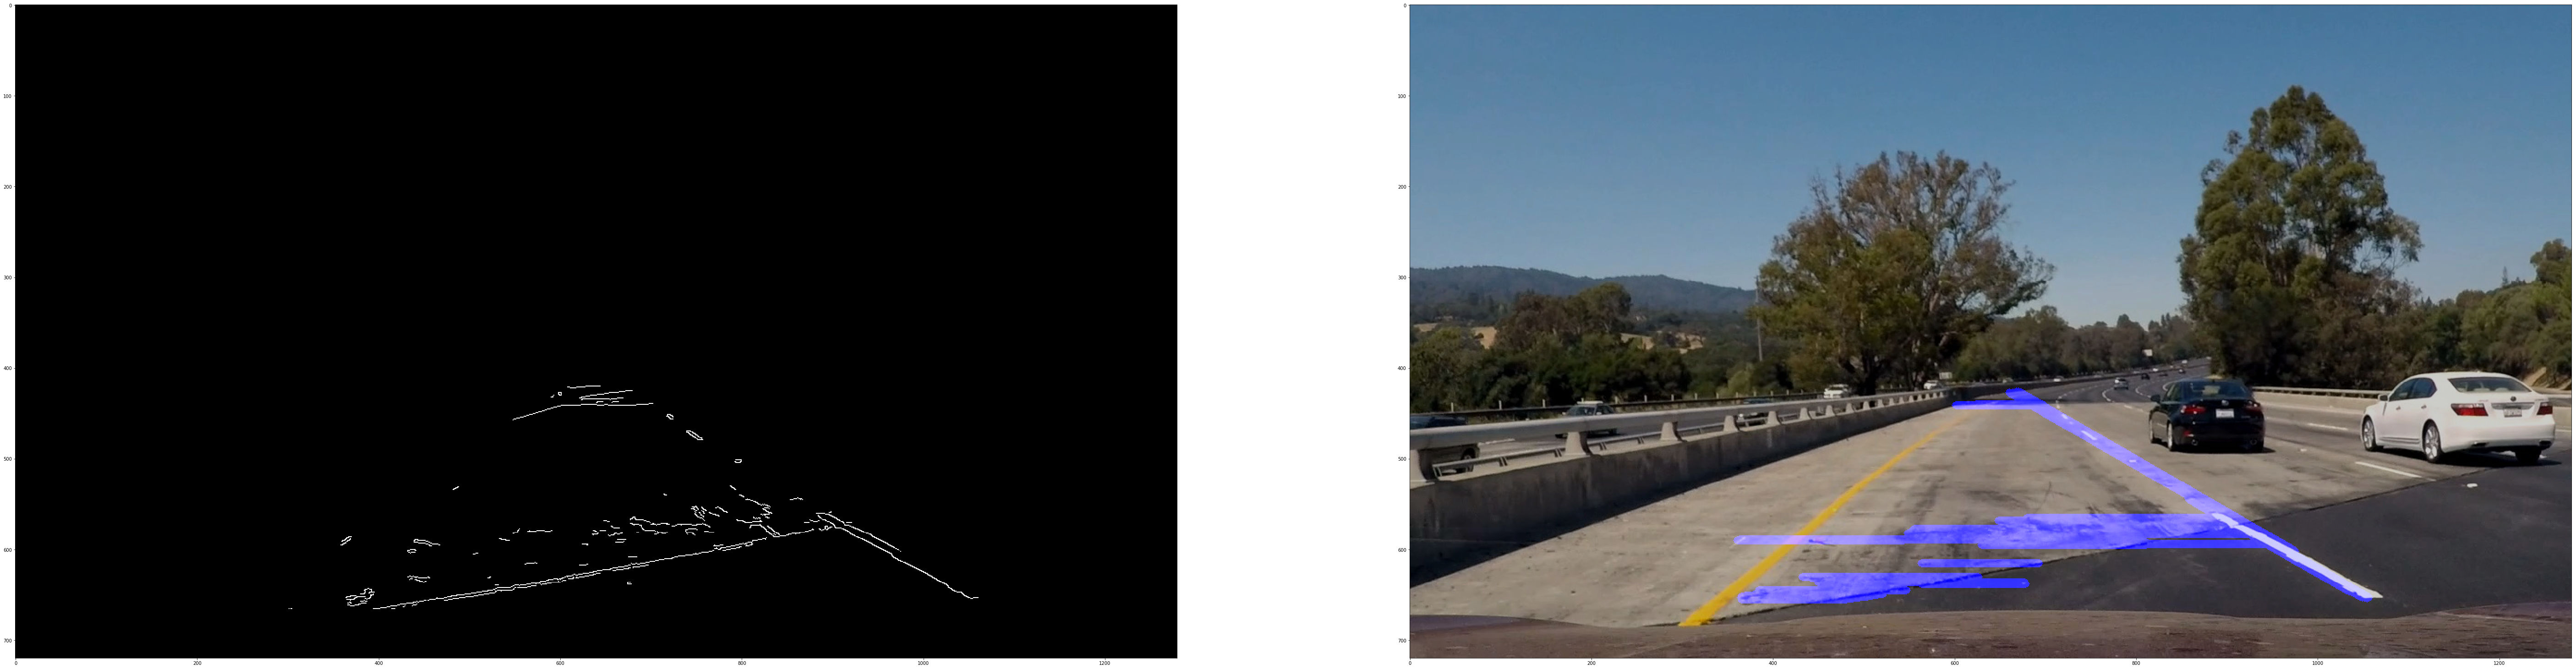

In [5]:
hough_image = None
def hough_transform(rho, theta, threshold, min_line_length, max_line_gap):
    global roi_image, image, hough_image
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    theta = theta * np.pi/180.0
    lines = cv2.HoughLinesP(roi_image, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    line_image = np.copy(image) * 0

    # Draw the original Hough lines detected
    for line in lines:
        for x0, y0, x1, y1 in line:
            cv2.line(line_image, (x0, y0), (x1, y1), (0, 0, 255), 8)

    # Create a "color" binary image to combine with line image
    # color_edges = np.dstack((edges, edges, edges))

    # Draw the lines on the edge image
    hough_image = cv2.addWeighted(image, 0.8, line_image, 1, 0)
    
    plt.clf()
    fig = plt.figure(figsize=(100, 100))
    
    plt.subplot(2, 2, 1)
    plt.imshow(roi_image, cmap='gray')
    plt.subplot(2, 2, 2)
    plt.imshow(hough_image, cmap='gray')

interact_manual(hough_transform,
         rho=widgets.IntSlider(min=1.0,max=11,step=1,value=1,continuous_update=False),
         theta=widgets.FloatSlider(min=1.0,max=90.0,step=1,value=30.0,continuous_update=False),
         threshold=widgets.IntSlider(min=1, max=100, step=1, value=10, continuous_update=False),
         min_line_length=widgets.IntSlider(min=1,max=255,step=1,value=5,continuous_update=False),
         max_line_gap=widgets.IntSlider(min=1,max=255,step=1,value=10,continuous_update=False))

# Process Video and dump individual frames

In [ ]:
def process_video_per_frame(input_video_filename, output_dir):
    vidcap = cv2.VideoCapture(input_video_filename)
    success,image = vidcap.read()
    count = 0
    success = True
    width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

    while success:
        success,image = vidcap.read()
        if not success:
          continue

        print_progress_bar(count, frame_count, prefix='Progress:', suffix='Complete', bar_length=50)
        cv2.imwrite(output_dir + "/frame%d.jpg" % count, image)     # save frame as JPEG file
#         edge_img, new_img = lane_detection_pipeline(image, global_extra_video_vals)
#         cv2.imwrite("IMG_FROM_FRAME/edge_%d.jpg" % count, edge_img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
#         cv2.imwrite("IMG_FROM_FRAME/overlay_%d.jpg" % count, new_img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
        count += 1

    vidcap.release()
    cv2.destroyAllWindows()